## Introduction

This notebook is to compute the spectra (differential reaction rate), for different isotopes. Mostly this is following http://adsabs.harvard.edu/abs/1996APh.....6...87L (Lewin and Smith, Review of Mathematics), and https://github.com/acolijn/Teaching/tree/master/DMUU/dictaat . Compares isotopes using a Helm Form factor.

To get your favorite plot, first execute imports and functions, then choose the plot and run the cell.

## Imports

In [1]:
import numpy as np
import scipy.special as sp
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=22)
plt.rcParams['figure.figsize'] = (10.0, 7.0)
# For multiple axes in one fig
from matplotlib import gridspec 
# For TeX fonts
plt.rc('text', usetex=True)

## Functions

In [2]:
def L_to_p(l, mode='hbar'): 
    '''
    convert momentum in fm to MeV/c 
    '''
    if mode == 'hbar':
        hc = 1973       # hBARc, in evAngstrom
    elif mode== 'h':
        hc = 12398.4193 # hRc, in evAngstrom
    else:
        raise SyntaxError('Mode not understood, please give h or hbar')
    p = hc*1e5/(l*1e6) # p in fm

    return p

In [3]:
def p_to_L(p, mode='hbar'): 
    '''convert momentum in MeV/c to fm'''
    if mode == 'hbar':
        hc = 1973       # hBARc, in evAngstrom
    elif mode== 'h':
        hc = 12398.4193 # hRc, in evAngstrom
    else:
        raise SyntaxError('Mode not understood, please give h or hbar')
    l = hc*1e5/(p*1e6) # l in fm

    return l

In [4]:
def F2_WoodsSaxon(q,A):
    '''
    # calculate the Woods-Saxon form factor
    # Equation 4.7 in Lewin and Smith, Review of mathematics ...

    # input: q - Momentum transfer
    #        A - atomic mass of the target
    #
    # return: F2 - F(q)^2
    '''
    
    # Nuclear size
    R = 1.2*A**(1./3)
    # 'nuclear skin thickness'
    s = 1 # fm
    R1 = math.sqrt(R**2-5*s**2)

    x  = R1/p_to_L(q)
    # sperical Bessel function j1(qR)
    j1 = sp.sph_jn(1,x)[0][1]

    F2 = (3*j1/x)*math.exp(-(s/p_to_L(q))**2)
    F2 = F2**2
    return F2

In [5]:
def sigma_WIMP_nucleus(**kwargs):
    """    
    Arguments for WIMP-nucleus cross section calculator

    INPUT:
    :param kwargs:
       sigma_SI - spin independent WIMP-nucleon cross-section
       mWIMP    - WIMP mass
       mN       - target mass
       
    RETURN:
       sigma    - WIMP nucleus cross-section
    """
    sigma_SI = kwargs.pop('sigma_SI', 1)
    mWIMP    = kwargs.pop('mWIMP', 100)
    mN       = kwargs.pop('mN', 100)  
    
    mp = 1 # nucleon mass in GeV/c2
    mu = mN*mWIMP/(mN+mWIMP)
    
    return sigma_SI*mu**2*mN**2/mp

In [6]:
def rcalc(mWIMP,mN):
    # calculate r
    return 4*mWIMP*mN/(mWIMP+mN)**2

In [7]:
def maxE(mWIMP, mN):
    vesc = 544e3 / 299792458 # in fraction of c
    E0 = 0.5 * mWIMP * vesc**2 * 1e6 # 1e6 for GeV to keV
    r = rcalc(mWIMP, mN)
    return r * E0

In [8]:
def intrate(Er, rates, mWIMP, mN, Emin=0):
    Emax = maxE(mWIMP, mN)
    dE = np.unique(np.diff(Er))[0] # assumes uniform spacing
    bools = (Er >= Emin) & (Er <= Emax)
    return np.sum(rates * bools) * dE

In [9]:
def Rpro(E,**kwargs):
    """    
    Recoil rate calculator.
    Optional to take into account: velocity of the earth, escape velocity, form factor
    Should revert to R(E) for vE->0, vesc -> inf, and form factor off, but somehow has a factor mN in between.

    INPUT:
    E     - recoil energy (keV)
    :param kwargs:
       R0    - 0th order rate ()
       mWIMP - WIMP mass (GeV/c2)
       mN    - nucleus mass (GeV/c2)
       v0    - most probable velocity (km/s)
       vE    - earth velocity
       vesc  - escape velocity
       dof2  - boolean to turn form factor off or on (default is off)
       
    RETURN:
       dRdE(E)
    """
    R0    = kwargs.pop('R0', 1)
    mWIMP = kwargs.pop('mWIMP', 100)
    mN    = kwargs.pop('mN', 100)
    v0    = kwargs.pop('v0', 220)    
    vE    = kwargs.pop('vE', 232)
    vesc  = kwargs.pop('vesc', 544)    
    dof2  = kwargs.pop('dof2',False)    
    
    v0=v0/3e5  # in units of c
    vesc=vesc/3e5
    vE=vE/3e5
    E0=mWIMP*v0**2/2*1e6 # in units of keV
    

    mu = mN*mWIMP/(mN+mWIMP)
    r  = rcalc(mWIMP,mN)

    vmin = np.sqrt(2*E/(mWIMP*r*1e6))
    E0=mWIMP*v0**2/2*1e6
    
    # normalization factor K
    vv   = vesc/v0
    vv2  = vesc**2/v0**2
    sqpi = np.sqrt(np.pi)
    # Equation 2.2 Lewin and Smith, with K = k0 / k1
    K = 1./(math.erf(vv)-2/sqpi*vv*np.exp(-vv2))
    x1 = (vmin+vE)/v0
    x2 = (vmin-vE)/v0
    # 3.13 in Lewin and Smith
    R = K*R0/(r*E0)*(sqpi*v0/(4*vE)*(math.erf(x1)-math.erf(x2))-np.exp(-vv2))
    
    # calculate form factor
    if dof2:
        q = math.sqrt(2*mN*E)
        F2 = F2_WoodsSaxon(q,mN)
    else:
        F2 = 1.0
    R = R*F2
    # R = R*F2*mN                  
    return R

In [10]:
def R(E, **kwargs):
    '''
    Basic rate equation.
    
    INPUT:
    E     - recoil energy (keV)
    :param kwargs:
       R0    - 0th order rate ()
       mWIMP - WIMP mass (GeV/c2)
       mN    - nucleus mass (GeV/c2)
       v0    - most probable velocity (km/s)
       
    RETURN:
       dRdE(E)
    '''
    R0    = kwargs.pop('R0', 1)
    mWIMP = kwargs.pop('mWIMP', 100)
    mN    = kwargs.pop('mN', 100)
    v0    = kwargs.pop('v0', 220)    
    
    v0=v0/3e5  # in units of c
    E0=mWIMP*v0**2/2*1e6 # in units of keV
    
    mu = mN*mWIMP/(mN+mWIMP)
    r  = rcalc(mWIMP,mN)
    E0=mWIMP*v0**2/2*1e6
    R = R0/(r*E0)*np.exp(-E/(E0*r))
    return R

In [11]:
def Rate0(mN, rho, sigma_SI, v0, mWIMP, mass_unit = 'g', time_unit='s'):
    '''
    Input:
        mN     - g/mol
        rho    - GeV/cm^3
        sigma0 - cm^2
        mWIMP  - GeV
        v0     - km/s
        sigma_SI
    
    Equation 3.1 in Lewin and Smith
    '''
    # Initial reshaping
    N0 = 6.022e23 # 1/mol
    v0 = v0 * 1000 * 100 # from km/s to cm/s
    
    # Calculation of sigma0 in terms of the SI cross section
    sigma0 = sigma_WIMP_nucleus(sigma_SI = sigma_SI, mWIMP=mWIMP, mN=mN)
    
    # Basic equation
    rate = 2 / (np.sqrt(np.pi)) * N0 / mN * rho / mWIMP * sigma0 * v0
    
    if mass_unit == 'g':
        rate = rate
    elif mass_unit == 'kg':
        rate = rate * 1000
    elif mass_unit == 'ton':
        rate = rate * 1e6
    elif mass_unit == 'kton':
        print('Nice detector, dude!')
        rate = rate * 1e9
    else:
        print('Warning: unrecognized mass unit, reverting to g')
    
    if time_unit == 's':
        rate = rate
    elif time_unit == 'day':
        rate = rate * 86400
    elif time_unit == 'year':
        rate = rate * 86400 * 365
    else:
        print('Warning: unrecognized time unit, reverting to s')
        
    return rate
    

In [12]:
def RR(Er, mN= 131, mWIMP = 100, sigma_SI = 1e-45, mass_unit='ton', time_unit='year', dof2=True):
    '''
    Get the differential rate for a list of recoil energies Er.
    '''
    diffrate = []
    for E in Er:
        # Normalization
        # sigma_SI = 1
        # sigma = sigma_WIMP_nucleus(sigma_SI=sigma_SI,mN=mN,mWIMP=mWIMP)
        # Don't know why
        R0 = Rate0(mN, rho = 0.3,v0=220, mWIMP=mWIMP, sigma_SI = sigma_SI, mass_unit=mass_unit, time_unit=time_unit)
        # Compute final rate and get result
        diffrate.append(Rpro(E,R0=R0,mWIMP=mWIMP,mN=mN,v0=220,vesc=544,vE=220,dof2=dof2))
    return np.array(diffrate)

## Plots

### Including Earth velocity

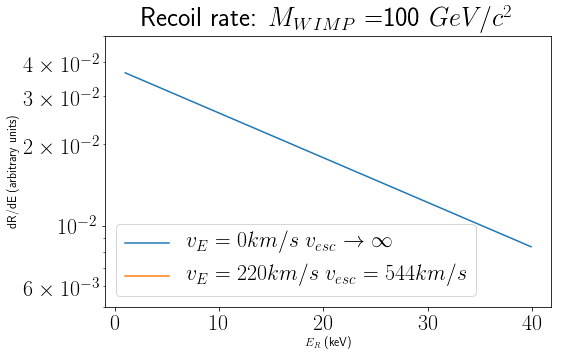

In [13]:
Er = np.arange(1,40,0.1)
R0 = []
R1 = []
R2 = []
lgd = []

mWIMP=100

for E in Er:

    R0.append(R(E,R0=1,mWIMP=mWIMP,mN=131,v0=220))
    lgd.append('$v_E=0 km/s$ $v_{esc}\\rightarrow\\infty$')
    R1.append(Rpro(E,R0=0.007,mWIMP=mWIMP,mN=131,v0=220,vesc=544,vE=220,dof2=False))
    lgd.append('$v_E=220km/s$ $v_{esc}=544km/s$')
    R2.append(Rpro(E,R0=1,mWIMP=100,mN=131,v0=220,vesc=544,vE=220,dof2=True))
    lgd.append('$v_E=220km/s$ $v_{esc}=544km/s F^2(q)$ Helm')


plt.semilogy(Er,R0,Er,R1)#,Er,R2)
plt.legend(lgd)

plt.title('Recoil rate: $M_{WIMP}$ ='+str(mWIMP)+' $GeV/c^2$')
plt.xlabel('$E_{R}$ (keV)',fontsize=12)
plt.ylabel('dR/dE (arbitrary units)',fontsize=12)


ax = plt.gca()
ax.set_ylim([5e-3 , 0.05])

fig = plt.gcf()
fig.set_size_inches(8,5)
# fig.savefig('plots/MovingEarth.pdf')
# fig.savefig('plots/MovingEarth.png')

### Different targets

max =  11088.8755452


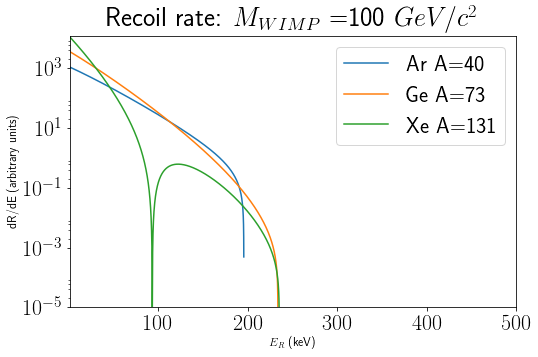

In [14]:
xmin = 1
xmax = 500
Er = np.arange(xmin,xmax,0.1)
RR0 = []
RR1 = []
RR2 = []
lgd = []

mWIMP=100
sigma_SI=1

for E in Er:
    # Argon
    mN = 40
    sigma = sigma_WIMP_nucleus(sigma_SI=sigma_SI,mN=mN,mWIMP=mWIMP)
    R0    = sigma/mN
    RR0.append(Rpro(E,R0=R0,mWIMP=100,mN=mN,v0=220,vesc=544,vE=220,dof2=True))
    lgd.append('Ar A=40')
    # Germanium
    mN = 73
    sigma = sigma_WIMP_nucleus(sigma_SI=sigma_SI,mN=mN,mWIMP=mWIMP)
    R0    = sigma/mN
    RR1.append(Rpro(E,R0=R0,mWIMP=100,mN=mN,v0=220,vesc=544,vE=220,dof2=True))
    lgd.append('Ge A=73')
    # Xenon
    mN = 131
    sigma = sigma_WIMP_nucleus(sigma_SI=sigma_SI,mN=mN,mWIMP=mWIMP)
    R0    = sigma/mN  
    RR2.append(Rpro(E,R0=R0,mWIMP=100,mN=mN,v0=220,vesc=544,vE=220,dof2=True))
    lgd.append('Xe A=131')
    
plt.semilogy(Er,RR0,Er,RR1,Er,RR2)
plt.legend(lgd)

plt.title('Recoil rate: $M_{WIMP}$ ='+str(mWIMP)+' $GeV/c^2$')
plt.xlabel('$E_{R}$ (keV)',fontsize=12)
plt.ylabel('dR/dE (arbitrary units)',fontsize=12)


ax = plt.gca()
print('max = ',max(RR2))
ax.set_ylim([1e-5,1.1*max(RR2)])
ax.set_xlim([xmin,xmax])

fig = plt.gcf()
fig.set_size_inches(8,5)
# fig.savefig('plots/Targets.pdf')
# fig.savefig('plots/Targets.png')

### Mean energy

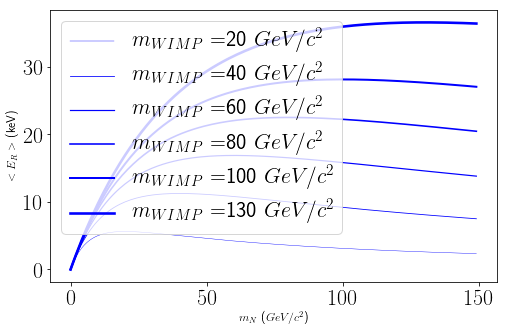

In [15]:
def plotErMean(mWIMP=[]):
    # plot the recoil spectrum
    mN = np.arange(0,150)
    v0=0.75e-3  # in c

    lgd = []
    for m in mWIMP:
        E0=m*v0**2/2*1e6
        plt.plot(mN,rcalc(mN,m)*E0,linewidth=2*m/100,color='blue')
        lstr = '$m_{WIMP}$ =' +str(m) + ' $GeV/c^2$'
        lgd.append(lstr)
    
    ax = plt.gca()
#    ax.set_yscale('log')
#    ax.set_ylim([0 , 1.1])

    plt.legend(lgd)

    #plt.title('Average $E_R$')
    plt.xlabel('$m_{N}$ ($GeV/c^2$)',fontsize=12)
    plt.ylabel('$<E_R>$ (keV)',fontsize=12)
    
    fig = plt.gcf()
    fig.set_size_inches(8,5)
    # fig.savefig('plots/ER_WIMP.pdf')
plotErMean([20, 40, 60, 80, 100, 130])

### Form factors

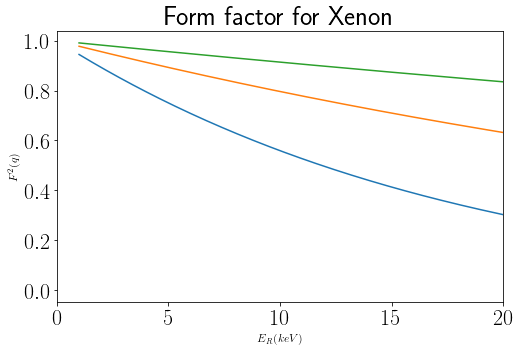

In [16]:
Er=np.arange(1,1000,0.1)

mN_Ar=40
mN_Ge=73
mN_Xe=131
lgd=[]

F2_Ar=[]
F2_Ge=[]
F2_Xe=[]

for E in Er:
    F2_Xe.append(F2_WoodsSaxon(math.sqrt(2*mN_Xe*E),mN_Xe))
    F2_Ge.append(F2_WoodsSaxon(math.sqrt(2*mN_Ge*E),mN_Ge))
    F2_Ar.append(F2_WoodsSaxon(math.sqrt(2*mN_Ar*E),mN_Ar))


plt.semilogy(Er,F2_Xe,Er,F2_Ge,Er,F2_Ar)
ax = plt.gca()
#ax.set_ylim([1e-8 , 1])

plt.title('Form factor for Xenon')
plt.xlabel('$E_R (keV)$',fontsize=12)
plt.ylabel('$F^2(q)$',fontsize=12)

fig = plt.gcf()
fig.set_size_inches(8,5)
plt.xlim(0, 20)
plt.yscale('linear')
# fig.savefig('plots/F2.pdf')

### Xenon recoils

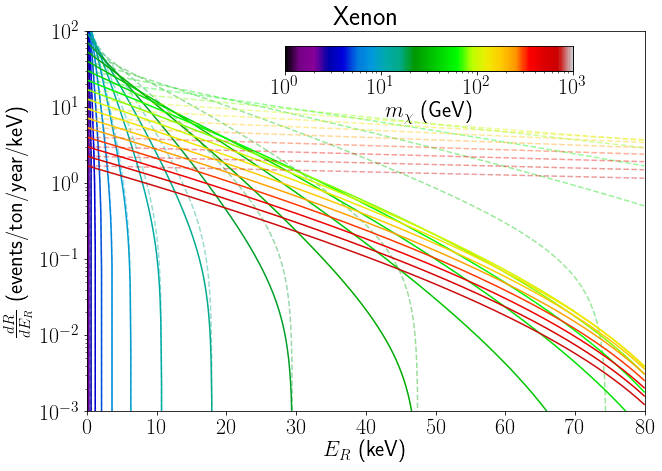

In [17]:
xmax = 80
colormax = 0.95
Er=np.arange(0.1 ,xmax, 0.1)
mWIMPs = np.logspace(0, np.log10(1000), 25)
num_plots = len(mWIMPs)
# http://matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html
colormap = plt.cm.spectral
colors = [colormap(i) for i in np.linspace(0, colormax, num_plots)]

for i, mWIMP in enumerate(mWIMPs):
    plt.plot(Er, RR(Er, mWIMP=mWIMP), label='mWIMP = %d' % mWIMP, color=colors[i])
    plt.plot(Er, RR(Er, mWIMP=mWIMP, dof2=False), label='mWIMP = %d' % mWIMP, color=colors[i], ls='--', alpha=0.4)

plt.yscale('log')
plt.xlim(0, xmax)

plt.ylim(1e-3, 100)
plt.xlabel(r'$E_R$ (keV)')
plt.ylabel(r'$\frac{dR}{dE_R}$ (events/ton/year/keV)')
plt.title('Xenon')

fig = plt.gcf()
fig.add_axes([0.4, 0.8, 0.4, 0.05])

plt.yticks([])
plt.xlim(min(mWIMPs), max(mWIMPs))
plt.xscale('log')
plt.xlabel('$m_{\chi}$ (GeV)')

# Plot colors
plt.twiny()
a = np.linspace(0, colormax, 256).reshape(1,-1)
plt.imshow(a, aspect='auto', cmap=plt.cm.spectral, origin='lower')
plt.xticks([])

plt.savefig('plots/xenonrate.pdf', bbox_inches='tight')

### Argon recoils

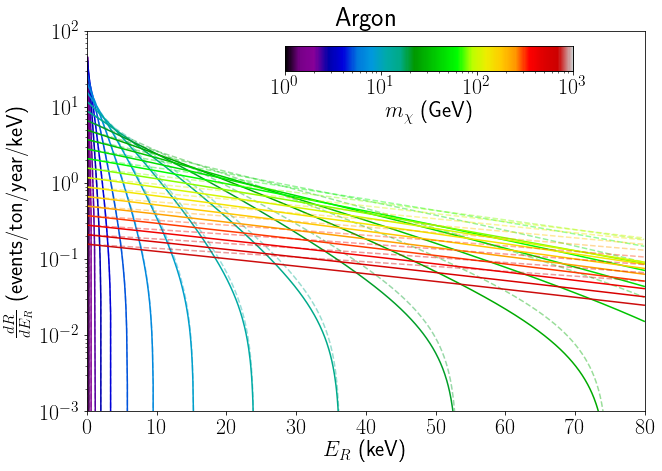

In [18]:
xmax = 80
colormax = 0.95
Er=np.arange(0.1 ,xmax, 0.1)
mWIMPs = np.logspace(0, np.log10(1000), 25)
num_plots = len(mWIMPs)
# http://matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html
colormap = plt.cm.spectral
colors = [colormap(i) for i in np.linspace(0, colormax, num_plots)]

for i, mWIMP in enumerate(mWIMPs):
    plt.plot(Er, RR(Er, mWIMP=mWIMP, mN=40), label='mWIMP = %d' % mWIMP, color=colors[i])
    plt.plot(Er, RR(Er, mWIMP=mWIMP, dof2=False, mN=40), label='mWIMP = %d' % mWIMP, color=colors[i], ls='--', alpha=0.4)

plt.yscale('log')
plt.xlim(0, xmax)

plt.ylim(1e-3, 100)
plt.xlabel(r'$E_R$ (keV)')
plt.ylabel(r'$\frac{dR}{dE_R}$ (events/ton/year/keV)')
plt.title('Argon')

fig = plt.gcf()
fig.add_axes([0.4, 0.8, 0.4, 0.05])

plt.yticks([])
plt.xlim(min(mWIMPs), max(mWIMPs))
plt.xscale('log')
plt.xlabel('$m_{\chi}$ (GeV)')

# Plot colors
plt.twiny()
a = np.linspace(0, colormax, 256).reshape(1,-1)
plt.imshow(a, aspect='auto', cmap=plt.cm.spectral, origin='lower')
plt.xticks([])

plt.savefig('plots/argonrate.pdf', bbox_inches='tight')

### Fancy combined figure

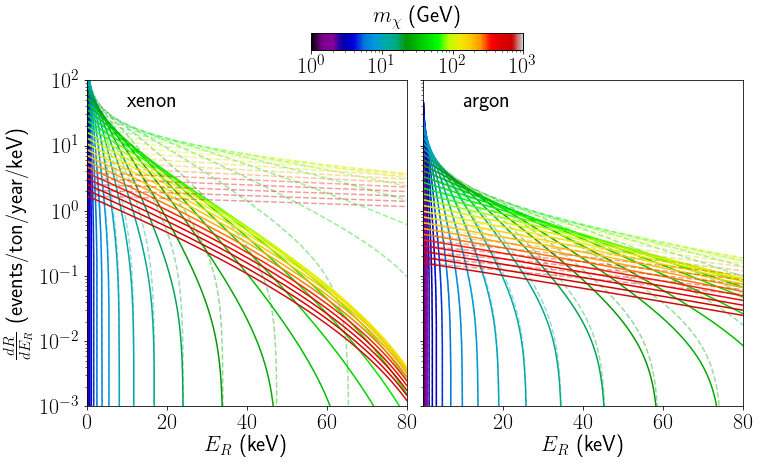

In [63]:
# Ratio of 1.0/0.85 is the plot width ratio in the thesis, so should give the same text size.
f = plt.figure(figsize=(10 * 1.0 / 0.85, 6.0))
xmax = 80
colormax = 0.95
Er=np.arange(0.1 ,xmax, 0.1)
mWIMPs = np.logspace(0, np.log10(1000), 35)
num_plots = len(mWIMPs)
colormap = plt.cm.spectral
colors = [colormap(i) for i in np.linspace(0, colormax, num_plots)]

gs = gridspec.GridSpec(1, 2, hspace = 0.05, wspace = 0.05) #width_ratios=[1,1,0.05], hspace=-50) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
axes = [ax0, ax1]



for ax, mN, title in zip(axes, [131, 40], ['xenon', 'argon']):
    plt.sca(ax)
   
    for i, mWIMP in enumerate(mWIMPs):
        plt.plot(Er, RR(Er, mWIMP=mWIMP, mN=mN), color=colors[i])
        plt.plot(Er, RR(Er, mWIMP=mWIMP, dof2=False, mN=mN), color=colors[i], ls='--', alpha=0.4)


    plt.yscale('log')
    plt.ylim(1e-3, 100)
    plt.xlim(0, xmax)
    plt.xlabel(r'$E_R$ (keV)')
    # plt.title(title)
    plt.text(10, 40, title)
    
# Remove one of the ticks
plt.sca(ax1)
plt.xticks([20, 40, 60, 80])

# plt.ylabel(r'$\frac{dR}{dE_R}$ (events/ton/year/keV)')

# Build the colorbar
fig = plt.gcf()
ax2 = fig.add_axes([0.39, 0.95, 0.25, 0.04])


plt.yticks([])
plt.xlim(min(mWIMPs), max(mWIMPs))
plt.xscale('log')
plt.xlabel('$m_{\chi}$ (GeV)')
# ax2.xaxis.set_label_coords(1.3, 1)
ax2.xaxis.set_label_coords(0.5, 2.5)

# Plot colors
plt.twiny()
a = np.linspace(0, colormax, 256).reshape(1,-1)
plt.imshow(a, aspect='auto', cmap=plt.cm.spectral, origin='lower')
plt.xticks([])



# Turn off ticks
ax = ax1
ax.set_ylabel("")
ax.set_yticklabels([])

plt.sca(ax0)
plt.ylabel(r'$\frac{dR}{dE_R}$ (events/ton/year/keV)')
plt.savefig('plots/rates.pdf', bbox_inches='tight')

## Numbers

### Cross-check the total rate

There are soooo many multiplications... Let's just compare the total number of events to the limit set in Xe1T first results, at 0.1 ty roughly. At 1e-45, it is just excluded at most WIMP masses, so we should have order unity events.

In [20]:
# Cross-check of the integrated rate
for mWIMP in mWIMPs:
    print('mW: %.1f,  %f interactions in Xe1T first results' % (mWIMP, 
                                                                intrate(Er, RR(Er, mWIMP=mWIMP, time_unit='year'),
                                                                        mWIMP, 131) * 34/365))

mW: 1.0,  0.000000 interactions in Xe1T first results
mW: 1.2,  0.000000 interactions in Xe1T first results
mW: 1.5,  0.316852 interactions in Xe1T first results
mW: 1.8,  0.944539 interactions in Xe1T first results
mW: 2.3,  2.018668 interactions in Xe1T first results
mW: 2.8,  3.332453 interactions in Xe1T first results
mW: 3.4,  4.924120 interactions in Xe1T first results
mW: 4.1,  6.730115 interactions in Xe1T first results
mW: 5.1,  8.740822 interactions in Xe1T first results
mW: 6.2,  10.956145 interactions in Xe1T first results
mW: 7.6,  13.478433 interactions in Xe1T first results
mW: 9.3,  16.203590 interactions in Xe1T first results
mW: 11.5,  19.103094 interactions in Xe1T first results
mW: 14.0,  22.083457 interactions in Xe1T first results
mW: 17.2,  24.957146 interactions in Xe1T first results
mW: 21.1,  27.459407 interactions in Xe1T first results
mW: 25.8,  29.314800 interactions in Xe1T first results
mW: 31.6,  30.255102 interactions in Xe1T first results
mW: 38.7,  30

In [21]:
# Cross-check of the integrated rate
for mWIMP in mWIMPs:
    print('mW: %.1f,  %f interactions in Xe1T first results' % (mWIMP, 
                                                                intrate(Er, RR(Er, mWIMP=mWIMP, mN=40, time_unit='year'),
                                                                        mWIMP, 40) * 34/365))

mW: 1.0,  0.141665 interactions in Xe1T first results
mW: 1.2,  0.310781 interactions in Xe1T first results
mW: 1.5,  0.521740 interactions in Xe1T first results
mW: 1.8,  0.775377 interactions in Xe1T first results
mW: 2.3,  1.052739 interactions in Xe1T first results
mW: 2.8,  1.362358 interactions in Xe1T first results
mW: 3.4,  1.721382 interactions in Xe1T first results
mW: 4.1,  2.106236 interactions in Xe1T first results
mW: 5.1,  2.528419 interactions in Xe1T first results
mW: 6.2,  2.984596 interactions in Xe1T first results
mW: 7.6,  3.469845 interactions in Xe1T first results
mW: 9.3,  3.968281 interactions in Xe1T first results
mW: 11.5,  4.461659 interactions in Xe1T first results
mW: 14.0,  4.925532 interactions in Xe1T first results
mW: 17.2,  5.332844 interactions in Xe1T first results
mW: 21.1,  5.651649 interactions in Xe1T first results
mW: 25.8,  5.858102 interactions in Xe1T first results
mW: 31.6,  5.932789 interactions in Xe1T first results
mW: 38.7,  5.869683 in

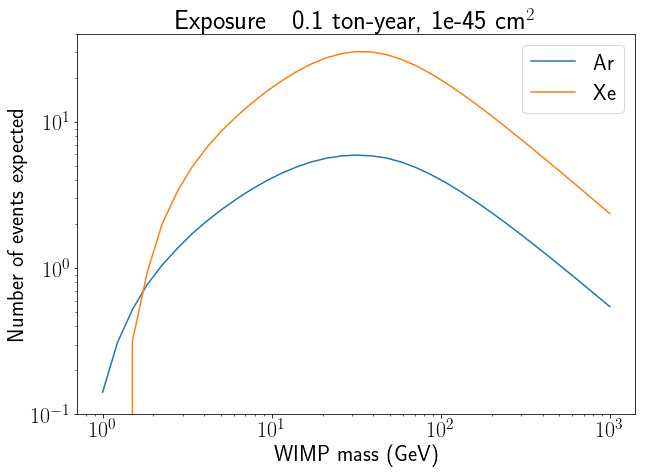

In [22]:
plt.plot(mWIMPs, 
         [intrate(Er, RR(Er, mWIMP=mWIMP, mN=40, time_unit='year'),mWIMP, 40) * 34/365 for mWIMP in mWIMPs], label = 'Ar')
plt.plot(mWIMPs, 
         [intrate(Er, RR(Er, mWIMP=mWIMP, mN=131, time_unit='year'),mWIMP, 131) * 34/365 for mWIMP in mWIMPs], label='Xe')
plt.xscale('log')
plt.xlabel('WIMP mass (GeV)')
plt.ylabel('Number of events expected')
plt.title('Exposure ~ 0.1 ton-year, 1e-45 cm^2')
plt.yscale('log')
plt.ylim(0.1, 40)
plt.legend()

### Typical energy transfer, wavelength, nuclear radius

The average energy transfer rE0 of a WIMP-nucleus scatter

In [23]:
mWIMP = 50
energy = rcalc(mWIMP, 131) * 0.5 * mWIMP * (220/3e5)**2 * 1e6
momentum = np.sqrt(2 * 131 * 1000 * energy / 1000) # in MeV/c
print("A %d GeV WIMP gives average energy %.1f keV and %.1f MeV momentum" % (mWIMP, energy, momentum))

A 50 GeV WIMP gives average energy 10.8 keV and 53.1 MeV momentum


In [24]:
# de Broglie wavelength calculated with hbar...
p_to_L(momentum)

3.7173455933379591

In [25]:
# ... and with h
p_to_L(momentum, mode='h')

23.359964191186673

In [26]:
# Nuclear radius of xenon ...
rnucleus = 1.2 * 131**(1/3)
rnucleus

6.09450369375924

In [27]:
# ... and Argon!
rnucleus = 1.2 * 40**(1/3)
rnucleus

4.103942272024073

In [28]:
# at about 55.5 MeV/c, the form factor will cut everyyting in half!
F2_WoodsSaxon(55.5, 131)

0.50310422494434781

In [29]:
# This is at recoil energy of about 11.8 keV
np.sqrt(2 * 131 * 11.8) # in MeV/c

55.602158231493142

### hbar or h?

For the form factor F2, we compute q * r_n to enter into the equation for the form factor. Do we do this correctly by using hbar, or do we need to set the de Broglie wavelength here?

It looks like we need hbar: we convert to units where hbar = 1 and c=1. 
To check this, let's look at a specific value. What is the dimensionless value of qrn (that enters into the Bessel functions) when Er = 95 keV (at the first dip in the xenon recoil graph?)?

In [30]:
def qrn(Er, A, an):
    '''Equation 4.1 Lewin'''
    return 6.92e-3 * A**0.5 * Er**0.5 * (an * A**(1/3))

In [31]:
qrn(95, 131, 1.2)

4.704807833870278

In [32]:
# Now recompute as done using p_to_L with h or hbar
momentum = np.sqrt(2 * 131 * 1000 * 95 / 1000) # in MeV/c
rn = 1.2 * (131)**(1/3)
rn / p_to_L(momentum, mode = 'hbar')

4.8733062873492523

In [33]:
rn / p_to_L(momentum, mode = 'h')

0.77550476978465099

Conclusion: hbar it is!